## Part I: Data Pre-processing

In [4]:
import pandas as pd

In [5]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

--2025-09-17 23:07:13--  http://download.tensorflow.org/data/questions-words.txt
正在查找主機 download.tensorflow.org (download.tensorflow.org)... 142.250.196.219, 142.250.198.91, 142.250.204.59, ...
正在連接 download.tensorflow.org (download.tensorflow.org)|142.250.196.219|:80... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 603955 (590K) [text/plain]
儲存到：「questions-words.txt」

questions-words.txt 100%[===================>] 589.80K  --.-KB/s  於 0.1s       

2025-09-17 23:07:13 (4.55 MB/s) - 已儲存 「questions-words.txt」 [603955/603955]



In [6]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [7]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [8]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.

questions = []
categories = []
sub_categories = []

semantic_count = 0
syntatic_count = 0
category_type = None

for line in data:
    if line.startswith(": "):
        sub_category = line.strip()
        if semantic_count < 5:
            category_type = "semantic"
            semantic_count += 1
        else:
            category_type = "syntatic"
            syntatic_count += 1
        current_sub_category = sub_category
    else:
        # Each analogy question is a line with 4 words
        questions.append(line)
        categories.append(category_type)
        sub_categories.append(current_sub_category)

# Print the first 5 processed rows for checking
for i in range(5):
    print(f"Question: {questions[i]}, Category: {categories[i]}, SubCategory: {sub_categories[i]}")


Question: Athens Greece Baghdad Iraq, Category: semantic, SubCategory: : capital-common-countries
Question: Athens Greece Bangkok Thailand, Category: semantic, SubCategory: : capital-common-countries
Question: Athens Greece Beijing China, Category: semantic, SubCategory: : capital-common-countries
Question: Athens Greece Berlin Germany, Category: semantic, SubCategory: : capital-common-countries
Question: Athens Greece Bern Switzerland, Category: semantic, SubCategory: : capital-common-countries


In [9]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [10]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,semantic,: capital-common-countries
2,Athens Greece Beijing China,semantic,: capital-common-countries
3,Athens Greece Berlin Germany,semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,semantic,: capital-common-countries


In [11]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [48]:
!pip install gensim

Defaulting to user installation because normal site-packages is not writeable


In [49]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [50]:
data = pd.read_csv("questions-words.csv")

In [51]:
MODEL_NAME = "glove-wiki-gigaword-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

The Gensim model loaded successfully!


In [53]:
# Pre-processing
import re
from typing import Optional
from gensim.utils import deaccent
from tqdm import tqdm

def preprocess_token(tok: str) -> str:
    """Basic preprocessing: remove accents, trim, lowercase, keep common characters"""
    tok = deaccent(tok).strip().lower()
    tok = re.sub(r"[^a-z0-9_\-']", "", tok)
    return tok

def resolve_in_vocab(w: str, model) -> Optional[str]:
    """Try to find an in-vocab variant of w in the model's vocabulary"""
    candidates = [w]
    if "-" in w: candidates.append(w.replace("-", "_"))
    if "_" in w: candidates.append(w.replace("_", "-"))
    if w.endswith("s") and len(w) > 3: candidates.append(w[:-1])
    if "'" in w: candidates.append(w.replace("'", ""))

    for cand in candidates:
        if cand in model.key_to_index:
            return cand
    return None

# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      a, b, c, d = analogy.split()
      golds.append(d.lower())

      if any(w.lower() not in model.key_to_index for w in (a, b, c)):
          preds.append(None)
          continue

      try:
          # b + c - a
          pred = model.most_similar(
              positive=[b.lower(), c.lower()],
              negative=[a.lower()],
              topn=1
          )[0][0]
      except KeyError:
          pred = None
      preds.append(pred)

100%|██████████| 19544/19544 [01:57<00:00, 166.68it/s]


In [56]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 65.3399481339497%
Category: syntatic, Accuracy: 61.255269320843084%
Sub-Category: capital-common-countries, Accuracy: 93.87351778656127%
Sub-Category: capital-world, Accuracy: 88.94783377541998%
Sub-Category: currency, Accuracy: 14.203233256351039%
Sub-Category: city-in-state, Accuracy: 30.806647750304013%
Sub-Category: family, Accuracy: 81.62055335968378%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 24.39516129032258%
Sub-Category: gram2-opposite, Accuracy: 20.073891625615765%
Sub-Category: gram3-comparative, Accuracy: 79.12912912912913%
Sub-Category: gram4-superlative, Accuracy: 54.278074866310156%
Sub-Category: gram5-present-participle, Accuracy: 69.50757575757575%
Sub-Category: gram6-nationality-adjective, Accuracy: 87.86741713570981%
Sub-Category: gram7-past-tense, Accuracy: 55.44871794871795%
Sub-Category: gram8-plural, Accuracy: 71.996996996997%
Sub-Category: gram9-plural-verbs, Accuracy: 58.39080459770115%


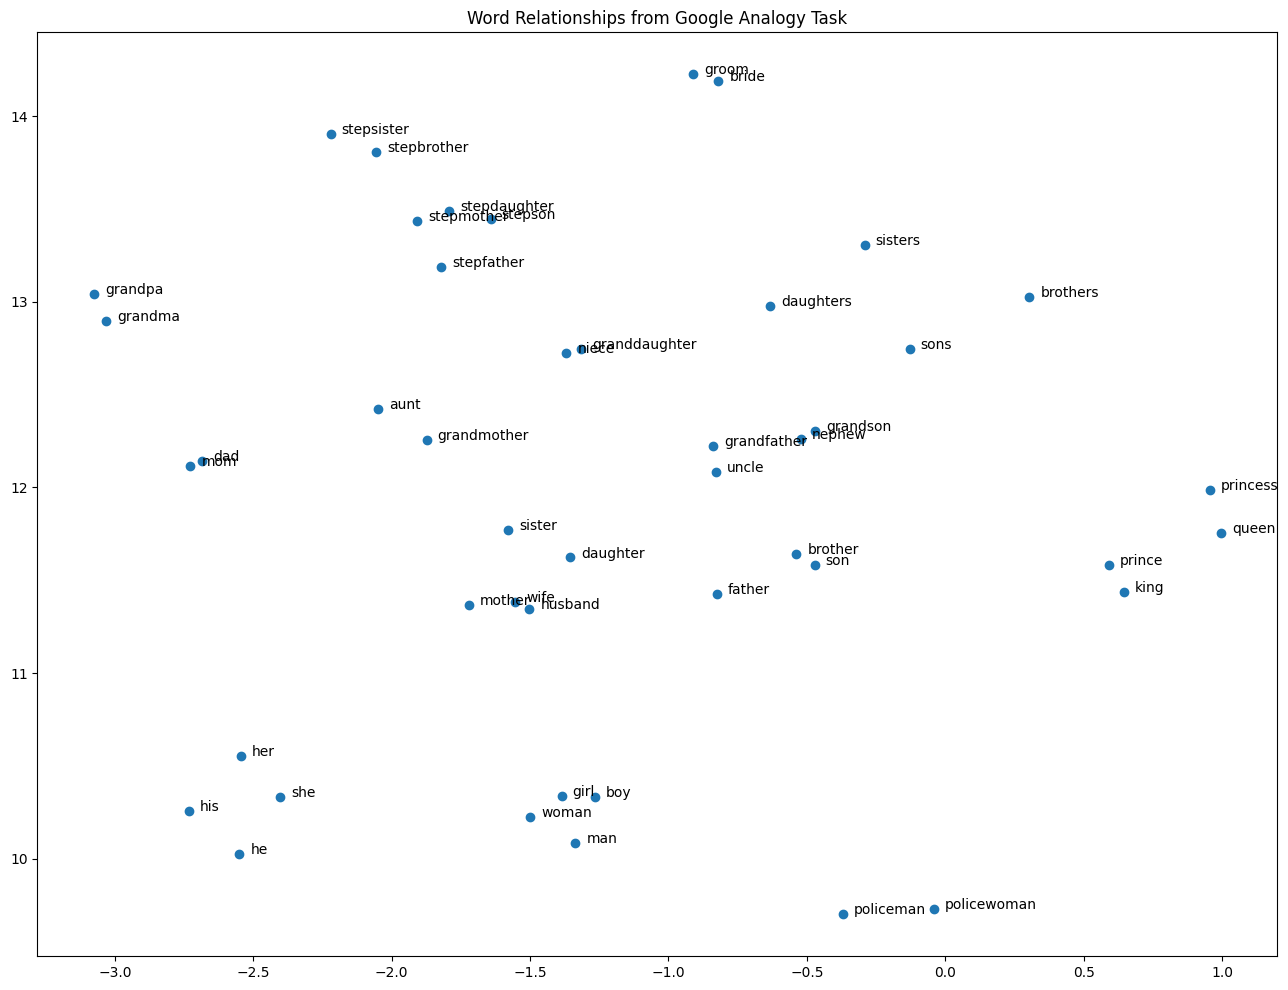

<Figure size 640x480 with 0 Axes>

In [57]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
sub_category_data = data[data.SubCategory == SUB_CATEGORY]
sub_category_data_str = " ".join(sub_category_data.Question)
words = np.unique(np.array(sub_category_data_str.split()))

words = [w for w in words if w in model.key_to_index]

X = np.array([model[w] for w in words])

embedded = TSNE(random_state=42).fit_transform(X)

plt.figure(figsize=(16, 12))
plt.scatter(embedded[:, 0], embedded[:, 1])

for idx, dots in enumerate(embedded):
    plt.annotate(words[idx], (dots[0] + 0.04, dots[1]))

plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")


### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

In [26]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

In [27]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [ ]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [29]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random

wiki_txt_path = "wiki_texts_combined.txt"
output_path = "wiki_texts_sampled.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
        import random
        random.seed(42)
        total, sampled = 0, 0

        for line in f:
            total += 1
            if random.random() < 0.2:
                output_file.write(line)
                sampled += 1

        print(f"Total articles: {total}")
        print(f"Sampled articles: {sampled} ({sampled/total:.2%})")
        print("Sampling done! Saved to", output_path)


Total articles: 5623655
Sampled articles: 1124733 (20.00%)
Sampling done! Saved to wiki_texts_sampled.txt


In [30]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.

import os, re
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.utils import simple_preprocess

SAMPLED_PATH = "wiki_texts_sampled.txt"
MODEL_PATH   = "my_w2v.model"
KV_PATH      = "my_w2v.kv"

class WikiSentences:
    def __init__(self, path):
        self.path = path
        self._sent_split = re.compile(r"[.!?。！？…]+")

    def __iter__(self):
        with open(self.path, "r", encoding="utf-8") as f:
            for article in f:
                article = article.strip()
                if not article:
                    continue

                for sent in self._sent_split.split(article):
                    sent = sent.strip()
                    if not sent:
                        continue

                    tokens = simple_preprocess(sent, deacc=True, min_len=2, max_len=30)
                    if len(tokens) >= 3:
                        yield tokens

sentences = WikiSentences(SAMPLED_PATH)


vector_size = 200
window      = 5
min_count   = 5
workers     = os.cpu_count() or 2
epochs      = 5
sg          = 1

w2v = Word2Vec(
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    sg=sg,
    negative=10,
    sample=1e-3,
    epochs=epochs
)


print("Building vocab...")
w2v.build_vocab(sentences, progress_per=100000)
print(f"Vocab size: {len(w2v.wv)}")

print("Training...")
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=w2v.epochs)


w2v.save(MODEL_PATH)
w2v.wv.save(KV_PATH)
print(f"Saved model to {MODEL_PATH} and vectors to {KV_PATH}")


def safe_most_similar(kv, word, topn=5):
    if word in kv.key_to_index:
        return kv.most_similar(word, topn=topn)
    return None

kv = w2v.wv
probe_words = ["king","queen","man","woman","city","country"]
for w in probe_words:
    res = safe_most_similar(kv, w)
    if res:
        print(f"most_similar('{w}'):", [p[0] for p in res])


Building vocab...
Vocab size: 1054999
Training...
Saved model to my_w2v.model and vectors to my_w2v.kv
most_similar('king'): ['queen', 'prince', 'nangklao', 'phutthaloetla', 'monarch']
most_similar('queen'): ['king', 'princess', 'jangnyeol', 'cheorin', 'inmok']
most_similar('man'): ['woman', 'girl', 'boy', 'person', 'old']
most_similar('woman'): ['man', 'girl', 'person', '俗女養成記', 'ohitika']
most_similar('city'): ['town', 'area', 'cities', 'citythe', 'district']
most_similar('country'): ['nation', 'startorder', 'countrytime', 'korrika', 'warrabri']


In [31]:
data = pd.read_csv("questions-words.csv")

In [32]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """

      if 'my_kv' not in globals():
          from gensim.models import KeyedVectors
          my_kv = KeyedVectors.load("my_w2v.kv", mmap='r')
          _to_lower = True

      parts = str(analogy).split()
      if len(parts) != 4:
          continue
      a, b, c, d = parts

      golds.append(d.lower() if _to_lower else d)

      if _to_lower:
          a, b, c = a.lower(), b.lower(), c.lower()

      if any(w not in my_kv.key_to_index for w in (a, b, c)):
          preds.append(None)
          continue

      try:
          pred = my_kv.most_similar(positive=[b, c], negative=[a], topn=1)[0][0]
      except KeyError:
          pred = None

      preds.append(pred)

100%|██████████| 19544/19544 [07:48<00:00, 41.71it/s]


/Users/carrie0925/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


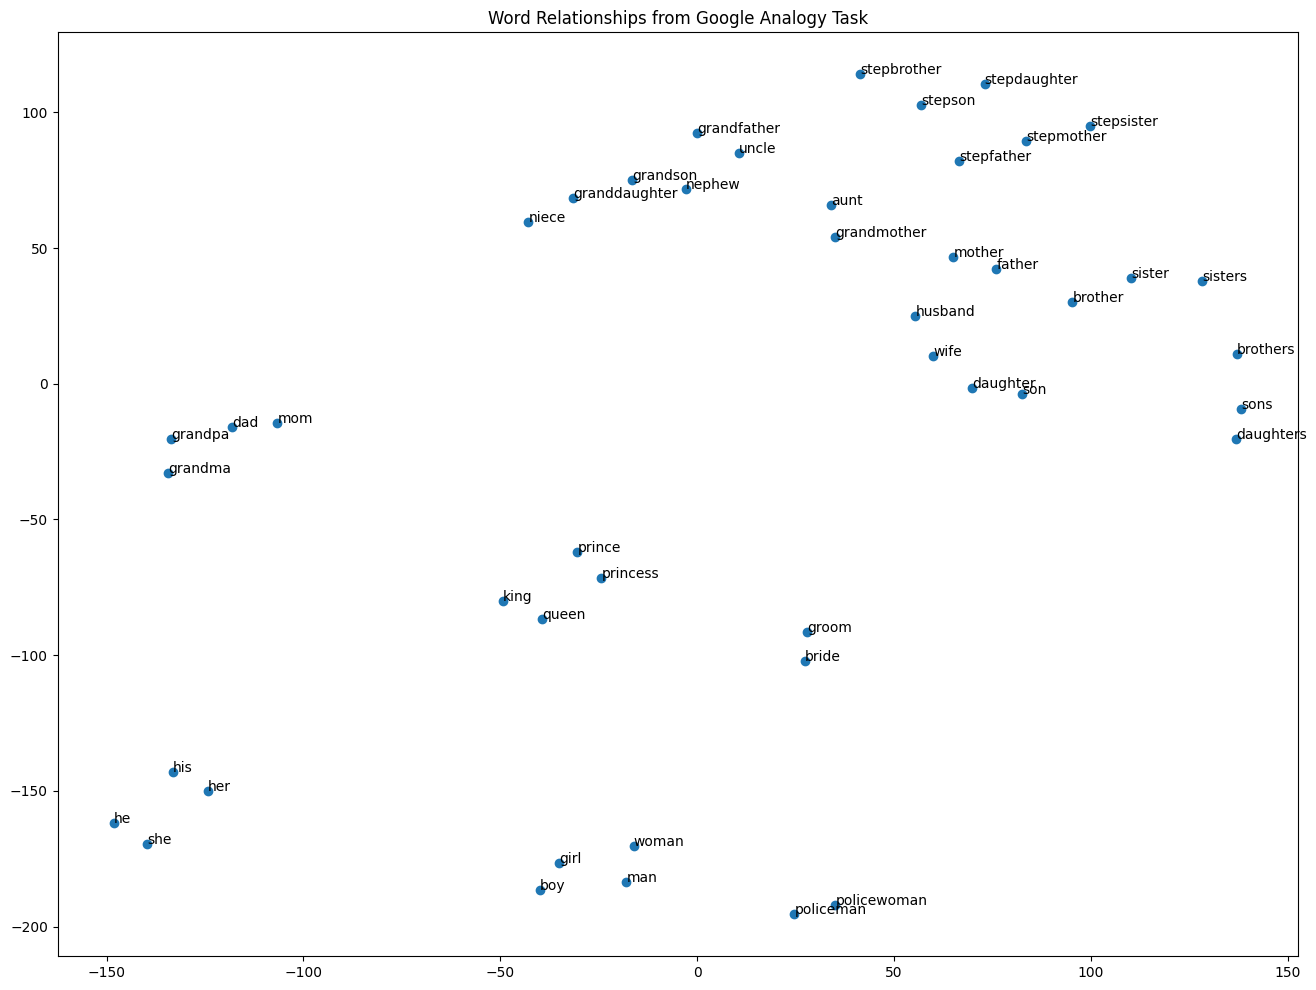

<Figure size 640x480 with 0 Axes>

In [33]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

if 'my_kv' not in globals():
    from gensim.models import KeyedVectors
    my_kv = KeyedVectors.load("my_w2v.kv", mmap='r')
    _to_lower = True

sub_df = data[data.SubCategory == SUB_CATEGORY]
words = sorted(set(" ".join(sub_df.Question).split()))
if _to_lower:
    words = [w.lower() for w in words]

words = [w for w in words if w in my_kv.key_to_index]

X = np.array([my_kv[w] for w in words])
if len(X) < 2:
    raise ValueError("Not enough in-vocab words in ': family' for t-SNE. Check your data/model.")


perp = max(2, min(5, len(X)//4))
tsne = TSNE(
    n_components=2,
    init="pca",
    perplexity=perp,
    learning_rate="auto",
    n_iter=1500,
    method="exact" if len(X) < 1000 else "barnes_hut",
    random_state=42
)
embedded = tsne.fit_transform(X)

plt.figure(figsize=(16, 12))
plt.scatter(embedded[:, 0], embedded[:, 1])
for idx, (x, y) in enumerate(embedded):
    plt.annotate(words[idx], (x + 0.04, y))

plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")